In [275]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims, weight_sharing=True):
        super().__init__()

        self.weight_sharing = weight_sharing
        self.activation_fn = nn.ReLU()

        # Encoder layers
        self.encoder_layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            self.encoder_layers.append(nn.Linear(prev_dim, h_dim))
            self.encoder_layers.append(self.activation_fn)
            prev_dim = h_dim
        self.encoder_layers.append(nn.Linear(prev_dim, latent_dim, bias=False))
        self.encoder = nn.Sequential(*self.encoder_layers)

        # Decoder uses the same weights as the encoder but in reverse order
        self.decoder_layers = []
        reversed_hidden_dims = list(reversed(hidden_dims))
        prev_dim = latent_dim
        for h_dim in reversed_hidden_dims:
            self.decoder_layers.append(nn.Linear(prev_dim, h_dim, bias=False))
            self.decoder_layers.append(self.activation_fn)
            prev_dim = h_dim
        self.decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*self.decoder_layers)

        # Weight sharing between encoder and decoder (if enabled)
        if self.weight_sharing:
            for enc_layer, dec_layer in zip(
                [l for l in self.encoder if isinstance(l, nn.Linear)],
                [l for l in self.decoder if isinstance(l, nn.Linear)][::-1]
            ):
                dec_layer.weight = nn.Parameter(enc_layer.weight.T)

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent


# Cosine similarity loss function
def cosine_similarity_loss(x, x_reconstructed):
    x_normalized = nn.functional.normalize(x, dim=1)
    x_reconstructed_normalized = nn.functional.normalize(x_reconstructed, dim=1)
    cosine_similarity = torch.sum(x_normalized * x_reconstructed_normalized, dim=1)
    loss = 1 - cosine_similarity.mean()
    return loss

def mse_loss(x, x_reconstructed):
    return F.mse_loss(x, x_reconstructed)

# Training function
def train_autoencoder(autoencoder, dataloader, epochs, learning_rate, device):
    optimizer = optim.AdamW(autoencoder.parameters(), lr=learning_rate, weight_decay=0.01)
    autoencoder.to(device)

    # Compile the model (PyTorch 2.0+)
    autoencoder = torch.compile(autoencoder)

    for epoch in range(epochs):
        total_loss = 0
        autoencoder.train()
        for data in dataloader:
            inputs = data[0].to(device)
            optimizer.zero_grad()
            reconstructed, _ = autoencoder(inputs)
            loss = mse_loss(inputs, reconstructed) #cosine_similarity_loss(inputs, reconstructed)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

# Function to compute explained variance ratio
def compute_explained_variance_ratio(autoencoder, data, device):
    autoencoder.eval()
    inputs = data.to(device)

    with torch.no_grad():
        reconstructed, _ = autoencoder(inputs)
        
        # Compute total variance
        total_variance = torch.sum((inputs - inputs.mean(dim=0)) ** 2).item()
        
        # Compute reconstruction variance (error)
        reconstruction_variance = torch.sum((inputs - reconstructed) ** 2).item()

    # Compute explained variance ratio
    explained_variance_ratio = 1 - (reconstruction_variance / total_variance)
    return explained_variance_ratio

# Example workflow
def run_generalized_autoencoder(embeddings, latent_dim, hidden_dims, batch_size=64, epochs=50, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)

    # Create DataLoader
    dataset = TensorDataset(embeddings_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize and train the autoencoder
    input_dim = embeddings.shape[-1]
    autoencoder = Autoencoder(input_dim, latent_dim, hidden_dims)
    train_autoencoder(autoencoder, dataloader, epochs, learning_rate, device)

    # Compute explained variance ratio using the full dataset
    explained_variance = compute_explained_variance_ratio(autoencoder, embeddings_tensor, device)
    print(f"Explained Variance Ratio: {explained_variance:.4f}")

    # Get latent vectors
    autoencoder.eval()
    with torch.no_grad():
        _, latent_vectors = autoencoder(embeddings_tensor.to(device))
    return latent_vectors.cpu().numpy()

# Example usage
embeddings = np.load("embeddings/embedding_tensor.npy")  # Load your data
latent_dim = 1  # Set the target dimensionality
hidden_dims = [128, 64, 32, 16]  # Define the sizes of the hidden layers
reduced_embeddings = run_generalized_autoencoder(
    embeddings, latent_dim, hidden_dims,
    batch_size=16, epochs=10, learning_rate=0.001
)

Epoch 1/10, Loss: 0.0507
Epoch 2/10, Loss: 0.0005
Epoch 3/10, Loss: 0.0005
Epoch 4/10, Loss: 0.0005
Epoch 5/10, Loss: 0.0005
Epoch 6/10, Loss: 0.0005
Epoch 7/10, Loss: 0.0005
Epoch 8/10, Loss: 0.0006
Epoch 9/10, Loss: 0.0006
Epoch 10/10, Loss: 0.0006
Explained Variance Ratio: -0.0976


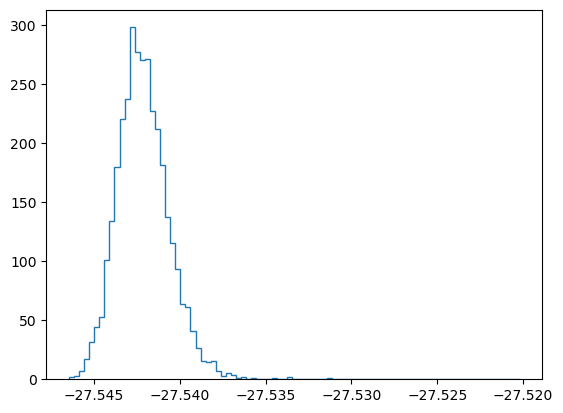

In [277]:
bandwidth = int(5e2 / len(embeddings) ** 0.2)
plt.hist(reduced_embeddings, density=True, bins=bandwidth, histtype="step")
plt.show()

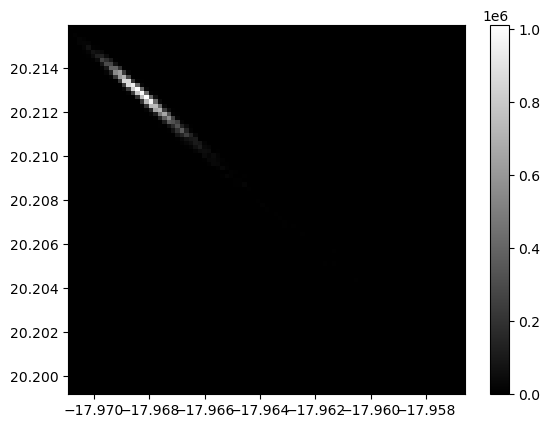

In [273]:
import matplotlib.pyplot as plt

bandwidth = int(5e2 / len(embeddings) ** 0.2)
plt.hist2d(*reduced_embeddings.T, density=True, bins=bandwidth, cmap="binary_r")
plt.colorbar()
#plt.xlim(-50, 50), plt.ylim(-50, 50)
plt.show()